# Doc2Vec DBOW with Logistic Regression and SVM

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc='progress-bar')
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split 
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

## Exploring and adjusting some values in the dataset

In [2]:
df = pd.read_json('IMDB_reviews.json', lines=True)

In [3]:
df.head()

,is_spoiler,movie_id,rating,review_date,review_summary,review_text,user_id
0,True,tt0111161,10,10 February 2006,A classic piece of unforgettable film-making.,"In its Oscar year, Shawshank Redemption (writt...",ur1898687
1,True,tt0111161,10,6 September 2000,Simply amazing. The best film of the 90's.,The Shawshank Redemption is without a doubt on...,ur0842118
2,True,tt0111161,8,3 August 2001,The best story ever told on film,I believe that this film is the best story eve...,ur1285640
3,True,tt0111161,10,1 September 2002,Busy dying or busy living?,"**Yes, there are SPOILERS here**This film has ...",ur1003471
4,True,tt0111161,8,20 May 2004,"Great story, wondrously told and acted",At the heart of this extraordinary movie is a ...,ur0226855


Checking if the dataset is balanced or not

In [4]:
df = df[['is_spoiler', 'review_text']]
df.is_spoiler = df.is_spoiler.astype(int)
df.head()

,is_spoiler,review_text
0,1,"In its Oscar year, Shawshank Redemption (writt..."
1,1,The Shawshank Redemption is without a doubt on...
2,1,I believe that this film is the best story eve...
3,1,"**Yes, there are SPOILERS here**This film has ..."
4,1,At the heart of this extraordinary movie is a ...


Number of reviews with spoilers: 150924 (26%)
Number of reviews without spoilers: 422989 (74%)


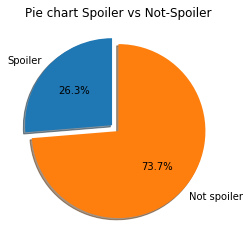

In [5]:
spoiler_length = len(df.loc[df['is_spoiler']==1])
not_spoiler_length = len(df.loc[df['is_spoiler']==0])

spoiler_percentage = (spoiler_length*100)/(spoiler_length + not_spoiler_length)
not_spoiler_percentage = (not_spoiler_length*100)/(spoiler_length + not_spoiler_length)

print('Number of reviews with spoilers: ' + str(spoiler_length) + ' (' + str(round(spoiler_percentage)) + '%)')
print('Number of reviews without spoilers: ' + str(not_spoiler_length) + ' (' + str(round(not_spoiler_percentage)) + '%)')

# Graphical Representation
labels = 'Spoiler', 'Not spoiler'
explode = (0.1, 0)
plt.pie([spoiler_length, not_spoiler_length], explode=explode, labels = labels,autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Pie chart Spoiler vs Not-Spoiler')
plt.show()

# Balancing the dataset

Random Undersampling


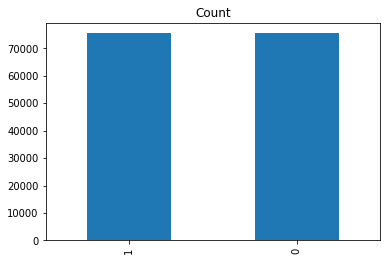

1    75462
0    75462
Name: is_spoiler, dtype: int64


In [6]:
# Class count
count_not_spoiler, count_spoiler = df.is_spoiler.value_counts()

# Divide by class
df_spoiler = df[ df['is_spoiler'] == 1 ]
df_not_spoiler = df[ df['is_spoiler'] == 0 ]

# Random undersampling
# We reduce the number of not spoiler to the number of spoiler
# We use floor division (//)
df_not_spoiler_under = df_not_spoiler.sample(int(count_spoiler//2))
df_spoiler_under = df_spoiler.sample(int(count_spoiler//2))
df_test_under = pd.concat([df_not_spoiler_under, df_spoiler_under], axis=0)

# The resulting dataset is balanced
print('Random Undersampling')
df_test_under.is_spoiler.value_counts().plot(kind='bar', title='Count')
plt.show()
print(df_test_under.is_spoiler.value_counts())

In [7]:
reviews = df_test_under['review_text'].values
y = df_test_under['is_spoiler'].values

# Splitting in training and test set
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, y, test_size=0.3, random_state=1000)

In [8]:
df_training = pd.DataFrame()
df_training['is_spoiler'] = y_train
df_training['review_text'] = reviews_train

df_test = pd.DataFrame()
df_test['is_spoiler'] = y_test
df_test['review_text'] = reviews_test

df_training.head()

,is_spoiler,review_text
0,0,A couple of things to get out of the way befor...
1,0,"Stanley Kubrick's ""The Shining"" is one of the ..."
2,0,"a really beautiful movie , that make you think..."
3,0,An absolutely fabulous tale of a boy who is lo...
4,0,"Before I start, let me say that I am a die-har..."


# Preprocessing
We start by defining the parameters that we are going to need for the preprocessing

In [9]:
# We create a map that takes the outputs of pos-tagging and convert them into the inputs of lemmatization
# We use name as the default value
pos_map = {
'CC': 'n', 'CD': 'n', 'DT': 'n', 'EX': 'n', 'FW': 'n', 'IN': 'n',
'JJ': 'a', 'JJR': 'a', 'JJS': 'a', 'LS': 'n', 'MD': 'v', 'NN': 'n', 'NNS': 'n', 'NNP': 'n',
'NNPS': 'n', 'PDT': 'n', 'POS': 'n', 'PRP': 'n', 'PRP$': 'r', 'RB': 'r', 'RBR': 'r', 'RBS': 'r',
'RP': 'n', 'TO': 'n', 'UH': 'n', 'VB': 'v', 'VBD': 'v', 'VBG': 'v',
'VBN': 'v', 'VBP': 'v', 'VBZ': 'v', 'WDT': 'n', 'WP': 'n', 'WP$': 'n', 'WRB': 'r'
}

In [10]:
from nltk.corpus import stopwords

# We define our stop words list
stop_words = set(stopwords.words('english'))
len(stop_words)

179

We define the tokenizer function

In [11]:
import nltk
from bs4 import BeautifulSoup
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

# We initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

def tokenizer(example_sent):
    # example_sent = "Hi, it's me"
    # Since all the stopwords are in lower case, we have to convert the string to lowercase first
    example_sent = example_sent.lower()

    # This was a simple tokenizer that kept the punctuation symbols
    # word_tokens = word_tokenize(example_sent)
    
    # Japanese words are kept as a single word, so we can remove them easily, but urls, emails and html tags are splitted, so we
    # have to remove them before tokenizing
    
    # Removing url, emails and html tags
    # HTML TAGS
    example_sent = BeautifulSoup(example_sent, 'lxml').text

    # EMAIL ADDRESSES
    example_sent = re.sub(r'[\w\.-]+@[\w\.-]+', ' ', example_sent)

    # URLs
    example_sent = re.sub(r'http\S+', '', example_sent)

    # Removing punctuation symbol
    tokenizer = RegexpTokenizer(r'\w+')
    word_tokens = tokenizer.tokenize(example_sent)
    # Now we have obtained the tokenized words without punctuation symbols and with stopwords

    # POS Tagging the data (the stopwords improve the accuracy of the pos tagging, so we'll remove them later)
    # This method returns a list of tuples: (word, classification)
    tags = nltk.pos_tag(word_tokens)

    # We lemmatize all the words in the text by their category
    for i, word in enumerate(word_tokens):
        # Returns the lemmatized word given its category (if the key is not part of the map, the word is considered a noun)
        word_tokens[i] = lemmatizer.lemmatize(word, pos=pos_map.get(tags[i][1] , 'n'))

    # Removing stop words
    filtered_sentence = [w for w in word_tokens if not w in stop_words]

    # In html:  <br>  -->  br
    # In email:  jua@gmail.com  --> jua, gmail, com
    # In url: https://www.youtube.com  --> http, www, youtube, com
    return filtered_sentence

In [12]:
# Testing the tokenizer
test = "<HTML>This <p>is.a</p> ! jua@email.com sentences, showing off the <br> stop words filtration. http://www.youtube.com"
tokenizer(test)

['sentence', 'show', 'stop', 'word', 'filtration']

This function takes 7 min with the reduced training set

In [13]:
df_training.head()

,is_spoiler,review_text
0,0,A couple of things to get out of the way befor...
1,0,"Stanley Kubrick's ""The Shining"" is one of the ..."
2,0,"a really beautiful movie , that make you think..."
3,0,An absolutely fabulous tale of a boy who is lo...
4,0,"Before I start, let me say that I am a die-har..."


In [14]:
# We randomize the order of the rows
df_training = df_training.sample(frac=1)
df_test = df_test.sample(frac=1)

df_training.head()

,is_spoiler,review_text
15772,1,This is a film that almost reached to the leve...
88841,1,I saw this today with my friends and i wanted ...
17964,1,"Ang Lee makes good looking movies. Here again,..."
41487,1,The positive stuff at first: The beginning sce...
8693,0,For those that know only of the original comic...


Tagging the training and test sets

In [15]:
%%time
# Tagging the training set
train_tagged = df_training.apply(lambda r: TaggedDocument(words=tokenizer(r['review_text']), tags=[r.is_spoiler]), axis = 1)

Wall time: 18min 58s


In [16]:
%%time
# Tagging the test set
test_tagged = df_test.apply(lambda r: TaggedDocument(words=tokenizer(r['review_text']), tags=[r.is_spoiler]), axis = 1)

Wall time: 8min 12s


In [17]:
test_tagged.values[1]

TaggedDocument(words=['remake', 'ever', 'surpass', 'predecessor', 'one', 'get', 'remarkably', 'close', 'definite', 'improvement', 'already', 'great', 'original', 'george', 'romero', 'zombie', 'classic', '1978', 'zack', 'snyder', 'would', 'go', 'direct', '300', 'watchman', 'unfortunately', 'sucker', 'punch', 'first', 'prove', 'talent', 'adapt', 'case', 'adapt', 'people', 'work', 'grip', 'gory', 'hugely', 'entertaining', 'horror', 'flick', 'zombie', 'plague', 'engulfs', 'america', 'band', 'survivor', 'barricade', 'shopping', 'mall', 'safety', 'tension', 'run', 'high', 'group', 'member', 'continue', 'find', 'attack', 'living', 'dead', 'eventually', 'choice', 'must', 'make', 'people', 'decide', 'stay', 'safe', 'get', 'everything', 'need', 'except', 'freedom', 'take', 'chance', 'storm', 'attempt', 'find', 'whether', 'people', 'still', 'alive', 'remote', 'secure', 'location', 'hope', 'join', 'story', 'remain', 'largely', 'except', 'absence', 'violent', 'marauding', 'biker', 'gang', 'invade',

# Set-up of Doc2Vec Training and Evaluation models

## Distributed Bag of Words (DBOW)

In [18]:
import multiprocessing

cores = multiprocessing.cpu_count()
cores

8

The number of dimensions is an **hyperparameter**

In [19]:
%%time
# This 300 dimensions and min_count=3
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=3, sample=0, workers=cores)

model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 2648239.87it/s]


Wall time: 3.49 s


In [20]:
%%time
# We will train during 100 epochs
epochs = 100
for epoch in range(epochs):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]),
                    total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002          # Original 0.002
    model_dbow.min_alpha = model_dbow.alpha
    print(epoch+1)

100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 2942482.89it/s]


1


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3653020.94it/s]


2


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3203037.71it/s]


3


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3418779.58it/s]


4


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3310334.46it/s]


5


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3153391.64it/s]


6


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 2803225.37it/s]


7


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 2775917.86it/s]


8


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3531331.21it/s]


9


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 2009320.54it/s]


10


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3531162.36it/s]


11


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3310383.93it/s]


12


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 2684661.54it/s]


13


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 2500572.45it/s]


14


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3783364.56it/s]


15


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3783364.56it/s]


16


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3417250.39it/s]


17


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3417224.03it/s]


18


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3650252.41it/s]


19


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3783396.86it/s]


20


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3024981.84it/s]


21


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3570398.45it/s]


22


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3652840.26it/s]


23


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3034594.17it/s]


24


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 2494912.56it/s]


25


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3652840.26it/s]


26


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 2854290.28it/s]


27


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 2380937.09it/s]


28


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3531162.36it/s]


29


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 2465291.20it/s]


30


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3923492.89it/s]


31


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3652900.48it/s]


32


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3417224.03it/s]


33


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3652900.48it/s]


34


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 2892485.61it/s]


35


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3310433.39it/s]


36


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3783041.56it/s]


37


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3923249.73it/s]


38


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3531049.81it/s]


39


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3531190.50it/s]


40


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3780524.02it/s]


41


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3653051.06it/s]


42


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3318739.35it/s]


43


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3310532.32it/s]


44


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3652960.71it/s]


45


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3652900.48it/s]


46


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3783461.47it/s]


47


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3783396.86it/s]


48


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3531162.36it/s]


49


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3310655.99it/s]


50


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 2546427.22it/s]


51


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3783590.69it/s]


52


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3475329.33it/s]


53


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3417118.62it/s]


54


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3640475.86it/s]


55


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3185812.25it/s]


56


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3652930.60it/s]


57


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3652810.15it/s]


58


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3923597.12it/s]


59


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 2076611.15it/s]


60


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3531162.36it/s]


61


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 2450769.84it/s]


62


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 2577443.10it/s]


63


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 2776143.95it/s]


64


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3652930.60it/s]


65


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3651937.10it/s]


66


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3783461.47it/s]


67


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3652870.37it/s]


68


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3531077.95it/s]


69


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3783235.35it/s]


70


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3781750.10it/s]


71


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 2254343.18it/s]


72


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3783364.56it/s]


73


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3783493.77it/s]


74


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3652900.48it/s]


75


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3652900.48it/s]


76


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3652870.37it/s]


77


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3783396.86it/s]


78


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3210277.84it/s]


79


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3648809.62it/s]


80


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3923736.09it/s]


81


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3209952.26it/s]


82


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3783396.86it/s]


83


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3783364.56it/s]


84


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3652990.83it/s]


85


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3105217.56it/s]


86


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3652930.60it/s]


87


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3778879.76it/s]


88


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3652930.60it/s]


89


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3780556.28it/s]


90


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3417197.68it/s]


91


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3115632.18it/s]


92


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3783461.47it/s]


93


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3783558.39it/s]


94


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3652719.81it/s]


95


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3531218.64it/s]


96


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3783526.08it/s]


97


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 2963956.12it/s]


98


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 3131640.27it/s]


99


100%|█████████████████████████████████████████████████████████████████████| 105646/105646 [00:00<00:00, 2445346.40it/s]


100
Wall time: 17min 46s


In [21]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    
    return targets, regressors

In [22]:
%%time
# We declare the values and the targets (for both train and testing set)
y_train, x_train = vec_for_learning(model_dbow, train_tagged) 
y_test, x_test = vec_for_learning(model_dbow, test_tagged) 

Wall time: 9min 19s


# Logistic Regression

In [23]:
%%time
# We compute the logistic Regression
logreg = LogisticRegression(n_jobs = 1, C=1e5)
logreg.fit(x_train, y_train)

D:\Users\Juan Carlos\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Wall time: 1min 54s


LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=1, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
%%time
# We predict the values for the test set given the trained agent
y_pred = logreg.predict(x_test) 

Wall time: 161 ms


In [25]:
# We compute f1-score and accuracy
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print('Testing accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('Testing Precision: ' + str(precision_score(y_test, y_pred)))
print('Testing Recall: ' + str(recall_score(y_test, y_pred)))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy: 0.5089005698131543
Testing Precision: 0.5091981027527815
Testing Recall: 0.5071299280384972
Testing F1 score: 0.5088990711891676


About number of dimensions: Typical interval is between 100-300. I would say you need at least 50D to achieve lowest accuracy. If you pick lesser number of dimensions, you will start to lose properties of high dimensional spaces. If training time is not a big deal for your application, i would stick with 200D dimensions as it gives nice features. Extreme accuracy can be obtained with 300D. After 300D word features won't improve dramatically, and training will be extremely slow.

# Support Vector Machine

**For Gaussian kernel:**
- Training accuracy: 0.5202093824542804
- Training Precision: 0.527418194893923
- Training Recall: 0.38874900609594487
- Training F1 score: 0.5117719072851213 
<br> <br>
- Testing accuracy: 0.5120112657388999
- Testing Precision: 0.5163104611923509
- Testing Recall: 0.3802186878727634
- Testing F1 score: 0.5033854263794245


**We have to modify the degree (default: 3)** <br>
**For Polynomial kernel:**

### Parameters for SVM
*Bibliography: https://medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769*
- **Gamma:** Parameter for non linear hyperplanes. The higher the gamma value it tries to exactly fit the training data set. <br>
```>>>gammas = [0.1, 1, 10, 100]```

- **C:** C is the penalty parameter of the error term. It controls the trade off between smooth decision boundary and classifying the training points correctly. Increasing C values may lead to overfitting the training data. <br>
```>>>cs = [0.1, 1, 10, 100, 1000]```

- **Degree:** Degree is a parameter used when kernel is set to 'poly'. It's the degree of the polynomial used to find the hyperplane to split the data. Using degree=1 is the same as using a ‘linear’ kernel. Also, increasing this parameters leads to higher training times. <br>
```>>>degrees = [0, 1, 2, 3, 4, 5, 6]```

First, we delete temporary training data to free up RAM.

In [26]:
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

13 minutes and 47s with reduced dataset, rbf kernel, gamma = 10 and C=1000 -> overfitting  (1. for all variables in training)<br>
1h 21 minutes 48s with reduced dataset, rbf kernel, gamma = 0.5 and C=100 -> overfitting (1. for all variables in training) <br>
4h 2min 45s with reduced dataset, rbf kernel, gamma = 0.1 and C=100 -> overfitting (.90 for all variables in training) <br>
6min 56s with reduced dataset, rbf kernel, gamma = 0.01 and C=10 -> underfitting:
- Training accuracy: 0.5371388815266366, Testing accuracy: 0.5019880715705766
- Training Precision: 0.5390510694628301, Testing Precision: 0.5020604395604396
- Training Recall: 0.5126557116353034, Testing Recall: 0.48442677269715045
- Training F1 score: 0.5368612643084398, Testing F1 score: 0.5018344377006682 <br>

21min 54s with reduced dataset, rbf kernel, gamma = 0.1 and C=10:
- Training accuracy: 0.7053074476543865, Testing accuracy: 0.4937872763419483
- Training Precision: 0.7119212092196157, Testing Precision: 0.4935042438939893
- Training Recall: 0.6897031539888683, Testing Recall: 0.47200132538104705
- Training F1 score: 0.7052356743153277, Testing F1 score: 0.4935468996924189 <br>

------------------ with reduced dataset, rbf kernel, gamma = 0.01 and C = 100:

In [27]:
%%time
import datetime

# Printing the starting time
datetime.datetime.now()
datetime.datetime(2009, 1, 6, 15, 8, 24, 78915)
print(datetime.datetime.now())

# Alternative 1: Support Vector Machines
from sklearn import svm

# We create the SVM and select a kernel
# poly: Polynomial Kernel
# rbf: Gaussian Kernel
# sigmoid: Sigmoid kernel
#
clf = svm.SVC(kernel='rbf', gamma=0.5, C=100, cache_size=7000)

# Train the model using the training sets
clf.fit(x_train, y_train)

2019-11-23 10:17:41.955840
Wall time: 15h 16min 18s


SVC(C=100, cache_size=7000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.5, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [28]:
%%time
y_pred_training_svm = clf.predict(x_train) 

Wall time: 57min 54s


In [29]:
# We compute f1-score and accuracy for the svm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# We check the accuracy for the training set
print('Training accuracy: ' + str(accuracy_score(y_train, y_pred_training_svm)))
print('Training Precision: ' + str(precision_score(y_train, y_pred_training_svm)))
print('Training Recall: ' + str(recall_score(y_train, y_pred_training_svm)))
print('Training F1 score: {}'.format(f1_score(y_train, y_pred_training_svm, average='weighted')))

Training accuracy: 1.0
Training Precision: 1.0
Training Recall: 1.0
Training F1 score: 1.0


In [30]:
%%time
y_pred_svm = clf.predict(x_test)

Wall time: 24min 50s


In [31]:
# We compute f1-score and accuracy for the svm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print('Testing accuracy: ' + str(accuracy_score(y_test, y_pred_svm)))
print('Testing Precision: ' + str(precision_score(y_test, y_pred_svm)))
print('Testing Recall: ' + str(recall_score(y_test, y_pred_svm)))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred_svm, average='weighted')))

Testing accuracy: 0.5050355581076903
Testing Precision: 0.5052914719111032
Testing Recall: 0.5058937795240829
Testing F1 score: 0.505035225651808
